In [19]:
# 1. Librerías que usaremos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import joblib, json, time, os

# Configuración estética
sns.set_theme(style="whitegrid")
%matplotlib inline

In [21]:
# 2. Ruta al archivo generado en Fase 1
RUTA_LOGS = "../1_Data/gov.log"

# Leemos línea a línea y convertimos a DataFrame
registros = []
with open(RUTA_LOGS, 'r') as f:
    for n, linea in enumerate(f):
        if n >= 100_000:          # límite para no saturar RAM
            break
        registros.append(json.loads(linea))

df = pd.DataFrame(registros)
print(f"Total de filas: {len(df)}")
df.head()

Total de filas: 100000


,timestamp,src_ip,dst_ip,service,status,sospechoso,user_agent,bytes,user
0,2025-11-21T06:52:31.542105,10.50.251,10.50.174,ssh,success,no,curl/7.68.0,4768,NaN
1,2025-11-21T09:29:40.542157,192.168.100.48,192.168.100.226,rdp,success,no,curl/7.68.0,2094,NaN
2,2025-11-20T20:55:09.542177,10.50.154,192.168.100.102,ftp,success,no,Mozilla/5.0 (Windows NT 10.0; Win64; x64),3281,NaN
3,2025-11-20T23:53:17.542193,10.50.37,192.168.100.55,ftp,success,no,Mozilla/5.0 (Windows NT 10.0; Win64; x64),2889,NaN
4,2025-11-21T09:19:55.542207,192.168.100.177,192.168.100.7,rdp,success,no,Mozilla/5.0 (Windows NT 10.0; Win64; x64),3138,NaN


In [22]:
# 3. Crear variables nuevas que el modelo entienda
df["hour"] = pd.to_datetime(df["timestamp"]).dt.hour        # Hora del día (0-23)
df["is_internet"] = ~df["src_ip"].str.startswith(("192.168.", "10.50."))  # ¿Viene de fuera?

# Variables que usaremos
caracteristicas_categoricas = ["service", "status", "sospechoso"]
caracteristicas_numericas   = ["hour", "bytes", "is_internet"]

print("Ejemplo de datos procesados:")
df[["hour", "bytes", "is_internet", "service", "status", "sospechoso"]].head()

Ejemplo de datos procesados:


,hour,bytes,is_internet,service,status,sospechoso
0,6,4768,False,ssh,success,no
1,9,2094,False,rdp,success,no
2,20,3281,False,ftp,success,no
3,23,2889,False,ftp,success,no
4,9,3138,False,rdp,success,no


In [23]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [24]:
# 4. Pre-procesador: one-hot para categóricas, pasa numéricas
preprocesador = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), caracteristicas_categoricas),
        ("num", "passthrough", caracteristicas_numericas)
    ])

# 5. IsolationForest
#    n_estimators = cantidad de árboles
#    contamination = proporción de anomalías que esperamos (5 %)
modelo = Pipeline(steps=[
    ("prep", preprocesador),
    ("clf",  IsolationForest(n_estimators=300,
                             contamination=0.05,
                             random_state=42,
                             n_jobs=-1))   # usa todos los cores
])

In [31]:
# 6. Separar X (features) de y (etiquetas reales que conocemos)
X = df_train[caracteristicas_categoricas + caracteristicas_numericas]
# y_true = (df["status"] == "failed").astype(int)   # 1 = ataque, 0 = normal
y_true = (df_test["sospechoso"] == "si").astype(int)

print("Entrenando modelo... (puede tardar 30-60 s)")
inicio = time.time()
modelo.fit(X)
duracion = time.time() - inicio
print(f"Listo en {duracion:.1f} s")

Entrenando modelo... (puede tardar 30-60 s)
Listo en 3.8 s


In [32]:
# 7. Predicción (-1 = anomalía, 1 = normal)
X_Test = df_test[caracteristicas_categoricas + caracteristicas_numericas]
y_pred = modelo.predict(X_Test)
y_pred = (y_pred == -1).astype(int)   # convertimos a 0/1

# 8. Añadir predicción al DataFrame
df_test["anomaly"] = y_pred
df_test["score"]   = modelo.decision_function(X_Test)  # cuanto más negativo, más anómalo

# 9. Guardar CSV para análisis externo
SALIDA_CSV = "predicciones_100k.csv"
df_test.to_csv(SALIDA_CSV, index=False)
print(f"Guardado: {SALIDA_CSV}")

Guardado: predicciones_100k.csv


=== Classification Report ===
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      4777
    Anomalia       0.99      1.00      0.99       223

    accuracy                           1.00      5000
   macro avg       0.99      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



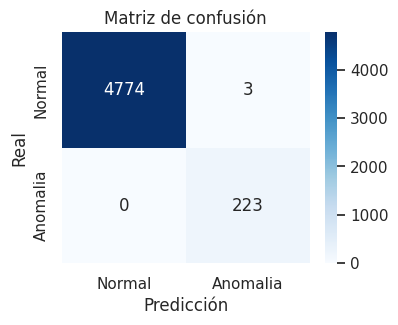

In [33]:
# 10. Resumen
print("=== Classification Report ===")
print(classification_report(y_true, y_pred,
                            target_names=["Normal", "Anomalia"]))

# 11. Matriz de confusión
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalia"],
            yticklabels=["Normal", "Anomalia"])
plt.title("Matriz de confusión")
plt.ylabel("Real"); plt.xlabel("Predicción")
plt.show()

=== Classification Report ===
              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95      4759
    Anomalia       0.04      0.04      0.04       241

    accuracy                           0.91      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.91      0.91      0.91      5000



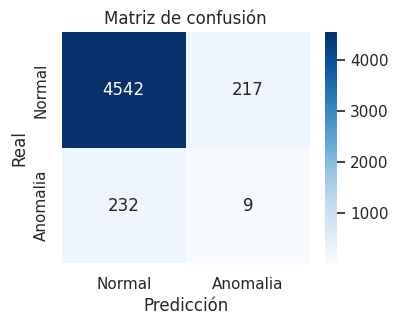

In [34]:
print("=== Classification Report ===")
X_Val = df_val[caracteristicas_categoricas + caracteristicas_numericas]
y_true = (df_val["sospechoso"] == "si").astype(int)
y_pred = modelo.predict(X_Test)
y_pred = (y_pred == -1).astype(int)   # convertimos a 0/1

print(classification_report(y_true, y_pred,
                            target_names=["Normal", "Anomalia"]))

# 11. Matriz de confusión
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalia"],
            yticklabels=["Normal", "Anomalia"])
plt.title("Matriz de confusión")
plt.ylabel("Real"); plt.xlabel("Predicción")
plt.show()

In [35]:
# 12. Guardar modelo entero (pre-procesador + árboles)
joblib.dump(modelo, "iforest_100k.pkl")
print("Modelo guardado: iforest_100k.pkl")

Modelo guardado: iforest_100k.pkl
